# Weighted Prediction Error

In [1]:
#!pip install soundfile librosa numpy pyroomacoustics matplotlib tqdm torch torchaudio

In [2]:
!git clone https://github.com/microsoft/DNS-Challenge

fatal: destination path 'DNS-Challenge' already exists and is not an empty directory.


In [3]:
import soundfile as sf
import librosa
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from tqdm import tqdm
import requests
import onnxruntime
%matplotlib inline

In [4]:
N_FTT = 512
HOP=128
WIN=512
WINDOW="blackman"
EPS=1e-10
COUNT_OF_FILES = 10

In [5]:
url = "https://drive.usercontent.google.com/download?id=1RarjxOgWkaDV8EjH_eLX169y89PVa3sg&confirm=t"
output = "nonblind_test.clean.zip"

if not Path(output).exists():
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    
    with open(output, 'wb') as file, tqdm(
        desc=output,
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    
    print("Файл успешно скачан:", output)
else:
    print("Файл уже найден")


Файл уже найден


In [6]:
path_single = Path("./single")
path_single.mkdir(exist_ok=True)

path_reverbed = Path("./single/reverbed")
path_reverbed.mkdir(exist_ok=True)

path_output_mono = Path("./single/output")
path_output_mono.mkdir(exist_ok=True)
print("Созданы директории:single/reverbed, single/output")

Созданы директории:single/reverbed, single/output


In [7]:
current_dir = Path(".")
data = Path("nonblind_test.clean.zip")
with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)
print("Архив успешно разархивирован в clean")

Архив успешно разархивирован в clean


In [8]:
def read_normalize(path):
    y, sr = sf.read(path)
    y = y / np.max(np.abs(y))
    return y, sr

In [9]:
y_clean, sr = read_normalize("clean/fileid_1.flac")
print(y_clean.shape, sr)

(336124,) 48000


## Single channel

In [10]:
def reverb_audio_single(y_clean, sr, plot=False):
    room_dim = [6.0, 4.0, 3]
    rt60 = 1
    
    absorption, max_order = pra.inverse_sabine(rt60, room_dim)
    
    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )
    
    src_pos = [5.0, 4, 1.7]
    mic_pos = [2.5, 2, 1.6]
    
    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*')
        ax.scatter(mic_pos[0], mic_pos[1], mic_pos[2],
               color='blue', s=200, marker='^')
        plt.title("Виртуальная комната")
        return None

        
    room.add_source(src_pos, signal=y_clean)
    
    mic = pra.MicrophoneArray(np.c_[mic_pos], room.fs)
    room.add_microphone_array(mic)
    
    room.simulate()
    return room.mic_array.signals[0]

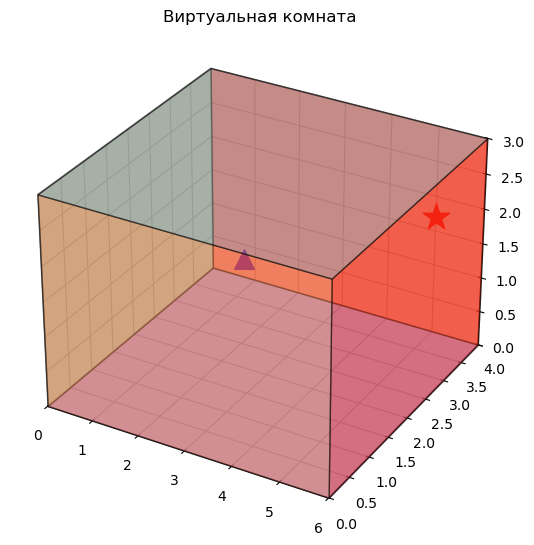

In [11]:
reverb_audio_single(y_clean, sr, plot=True)

In [12]:
y_reverbed = reverb_audio_single(y_clean, sr)
sf.write(path_reverbed / "test.flac", y_reverbed, sr)

In [13]:
def plot_audio_spectrogram(y, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW):
    if y.ndim == 1:
        y = np.expand_dims(y, axis=0)
    
    num_channels = y.shape[0]

    plt.figure(figsize=(10, 3 * num_channels))
    
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        
        D = np.abs(librosa.stft(y[i], n_fft=n_fft, hop_length=hop_length,
                                win_length=win_length, window=window))
        D_db = librosa.amplitude_to_db(D, ref=np.max)
        
        librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                                 x_axis='time', y_axis='hz', cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Канал {i+1}")
    
    plt.tight_layout()
    plt.show()

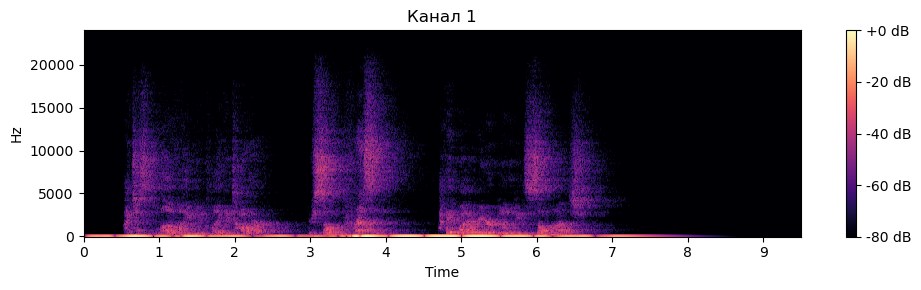

In [14]:
plot_audio_spectrogram(y_reverbed, sr)

In [15]:
def moving_avg_power(x, win_len):
    power = np.abs(x)**2
    w = np.ones(win_len, dtype=float) / max(1, win_len)
    return np.convolve(power, w, mode="same")
    
def wpe_mono(
    y, sr,
    n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW, eps=EPS,
    D=3, L=10, N=3, reg=1e-6
):

    Y = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win, window=window)
    F, T = Y.shape
    Z = Y.copy()

    t_min = D + L - 1

    for f in range(F):
        yf = Y[f, :]
        if np.allclose(yf, 0):
            continue

        idx = np.arange(t_min, T)
        if idx.size == 0:
            continue

        X = np.vstack([yf[idx - D - l] for l in range(L)])

        lam_full = np.maximum(moving_avg_power(yf, win_len=L), eps)
        lam = lam_full[idx]

        for _ in range(N):

            A = (X.T) / lam[:, None]
            b = (yf[idx]) / lam

            AH = A.conj().T
            R = AH @ A
            R += reg * np.eye(L, dtype=R.dtype)
            p = AH @ b
            g = np.linalg.solve(R, p)

            pred = (X.conj().T @ g)
            z_valid = yf[idx] - pred

            power_all = np.abs(yf)**2
            power_all[idx] = np.abs(z_valid)**2
            lam_full = np.maximum(moving_avg_power(power_all, win_len=L), eps)
            lam = lam_full[idx]

        Z[f, :t_min] = yf[:t_min]
        Z[f, idx] = z_valid

    y_hat = librosa.istft(Z, hop_length=hop, win_length=win, window=window, length=len(y))
    return y_hat

In [16]:
y_wpe = wpe_mono(y_reverbed, sr, D=3, L=10, N=3)

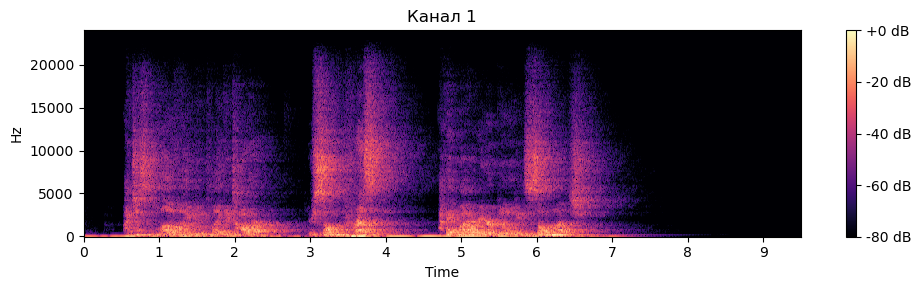

In [17]:
plot_audio_spectrogram(y_wpe, sr)

# Метрики

In [18]:
def fwsegsnr(clean, enhanced, sr, eps=EPS,
             n_fft=WIN, hop=HOP, win=WIN, window=WINDOW):
    X = np.abs(librosa.stft(clean, n_fft=n_fft, hop_length=hop, win_length=win, window=window))
    Xh = np.abs(librosa.stft(enhanced, n_fft=n_fft, hop_length=hop, win_length=win, window=window))

    F, T = X.shape
    fwseg = 0

    for t in range(T):
        w = X[:, t] ** 2
        if np.sum(w) == 0:
            continue
        w /= (np.sum(w) + eps)
        
        num = X[:, t] ** 2
        den = (X[:, t] - Xh[:, t]) ** 2 + eps
        snr_f = np.log10(num / (den + eps))

        fwseg += np.sum(w * snr_f)

    fwseg = 10 * fwseg / (T + eps)
    return fwseg

def cepstral_distance(clean, enhanced, sr, n_mfcc=13):
    clean = clean / np.max(np.abs(clean))
    enhanced = enhanced / np.max(np.abs(enhanced))
    C = librosa.feature.mfcc(y=clean, sr=sr, n_mfcc=n_mfcc)
    Ch = librosa.feature.mfcc(y=enhanced, sr=sr, n_mfcc=n_mfcc)
    T = min(C.shape[1], Ch.shape[1])
    C = C[:, :T]
    Ch = Ch[:, :T]
    diff = (C - Ch) ** 2
    per_frame = np.sqrt(np.sum(diff, axis=0))
    CD = np.mean(per_frame)
    return CD

def DNSMOS(y, sr):
    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        sr = 16000

    target_len = 144160
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    
    input_audio = np.expand_dims(y.astype(np.float32), axis=0)  
    session = onnxruntime.InferenceSession("DNS-Challenge/DNSMOS/DNSMOS/sig_bak_ovr.onnx")
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_audio})
    # Overall, Speech Mos, Background Mos
    return outputs[0]
    
    

In [19]:
print("Для реверберированного:")
print("FWSegSNR:", fwsegsnr(y_clean, y_reverbed, sr))
print("CD:", cepstral_distance(y_clean, y_reverbed, sr))
print("DNSMOS:", DNSMOS(y_reverbed, sr))

print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))
print("DNSMOS:", DNSMOS(y_wpe, sr))

Для реверберированного:
FWSegSNR: -17.392232541022064
CD: 131.10582489173865
DNSMOS: [[2.5062284 3.5473146 2.4061217]]
Для очищенного
FWSegSNR: -7.250432151760782
CD: 178.11571621709064
DNSMOS: [[1.5619622 1.6721668 1.350639 ]]


In [20]:
y_wpe2 = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)
print("Для L = 15")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe2, sr))
print("CD:", cepstral_distance(y_clean, y_wpe2, sr))

Для L = 15
FWSegSNR: -4.334052461027096
CD: 163.3953450610414


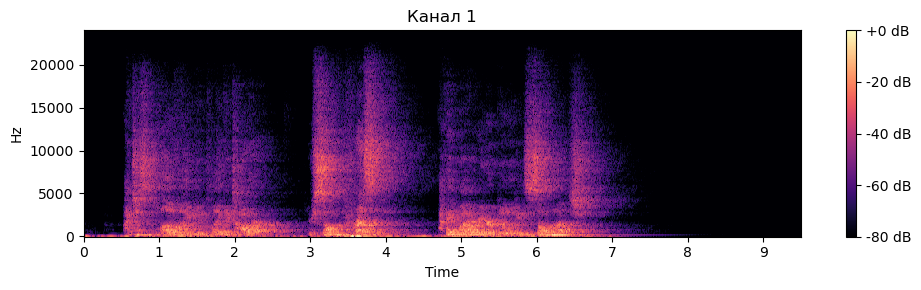

In [21]:
plot_audio_spectrogram(y_wpe2, sr)

### Ревербирируем датасет и применяем WPE

In [22]:
path_clean = Path("clean")

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
dnsmos_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = sf.read(path_clean / file.name)
    y_reverbed = reverb_audio_single(y_clean, sr)
    y_wpe = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    dnsmos_metric[audio_index] = DNSMOS(y_wpe, sr)[0, 0]
    audio_index += 1

    sf.write(path_reverbed / file.name, y_reverbed, sr)
    sf.write(path_output_mono / file.name, y_wpe, sr)

In [23]:
print("FWSegSNR")
print("Min:", np.min(fwsegsnr_metric))
print("Max:", np.max(fwsegsnr_metric))
print("Mean:", np.mean(fwsegsnr_metric))

FWSegSNR
Min: -9.125290224585953
Max: 1.5201134262064784
Mean: -4.5248882362864835


In [24]:
print("Cepstral Distance")
print("Min:", np.min(cd_metric))
print("Max:", np.max(cd_metric))
print("Mean:", np.mean(cd_metric))

Cepstral Distance
Min: 69.70195693272271
Max: 163.64463502313097
Mean: 113.91830607261292


In [25]:
print("DNSMOS")
print("Min:", np.min(dnsmos_metric))
print("Max:", np.max(dnsmos_metric))
print("Mean:", np.mean(dnsmos_metric))

DNSMOS
Min: 1.3919378519058228
Max: 2.6928091049194336
Mean: 2.0524598360061646


## Multi-channel

In [26]:
path_multiple = Path("./multiple")
path_multiple.mkdir(exist_ok=True)

path_reverbed = Path("./multiple/reverbed")
path_reverbed.mkdir(exist_ok=True)

path_output_multi = Path("./multiple/output")
path_output_multi.mkdir(exist_ok=True)
print("Созданы директории:multiple/reverbed, multiple/output")

Созданы директории:multiple/reverbed, multiple/output


In [27]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

def reverb_audio_multi(y_clean, sr, plot=False):
    room_dim = [8.0, 6.0, 3.0] 
    rt60 = 1

    absorption, max_order = pra.inverse_sabine(rt60, room_dim)

    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )

    src_pos = [7.0, 1.0, 1.7]

    mic_center = np.array([2.0, 4.5, 1.6])
    d = 0.5
    num_mics = 5

    mic_positions = np.zeros((3, num_mics))
    for i in range(num_mics):
        mic_positions[:, i] = mic_center + np.array([ \
        d * (i - (num_mics - 1) / 2),
        0.15 * (i - (num_mics - 1) / 2),
        0.0
    ])

    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*', label='Источник')
        ax.scatter(mic_positions[0, :], mic_positions[1, :], mic_positions[2, :],
                   color='blue', s=200, marker='^', label='Массив микрофонов')
        plt.legend()
        plt.title("Виртуальная комната с 5 микрофонами")
        plt.show()
        return

    room.add_source(src_pos, signal=y_clean)
    room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))

    room.simulate()

    return room.mic_array.signals


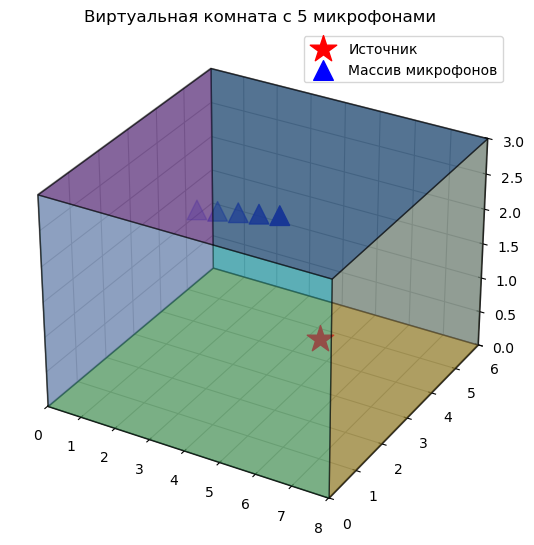

In [28]:
reverb_audio_multi(y_clean, sr, plot=True)

In [29]:
y_reverbed = reverb_audio_multi(y_clean, sr)
sf.write(path_reverbed / "test.flac", y_reverbed.T, sr)

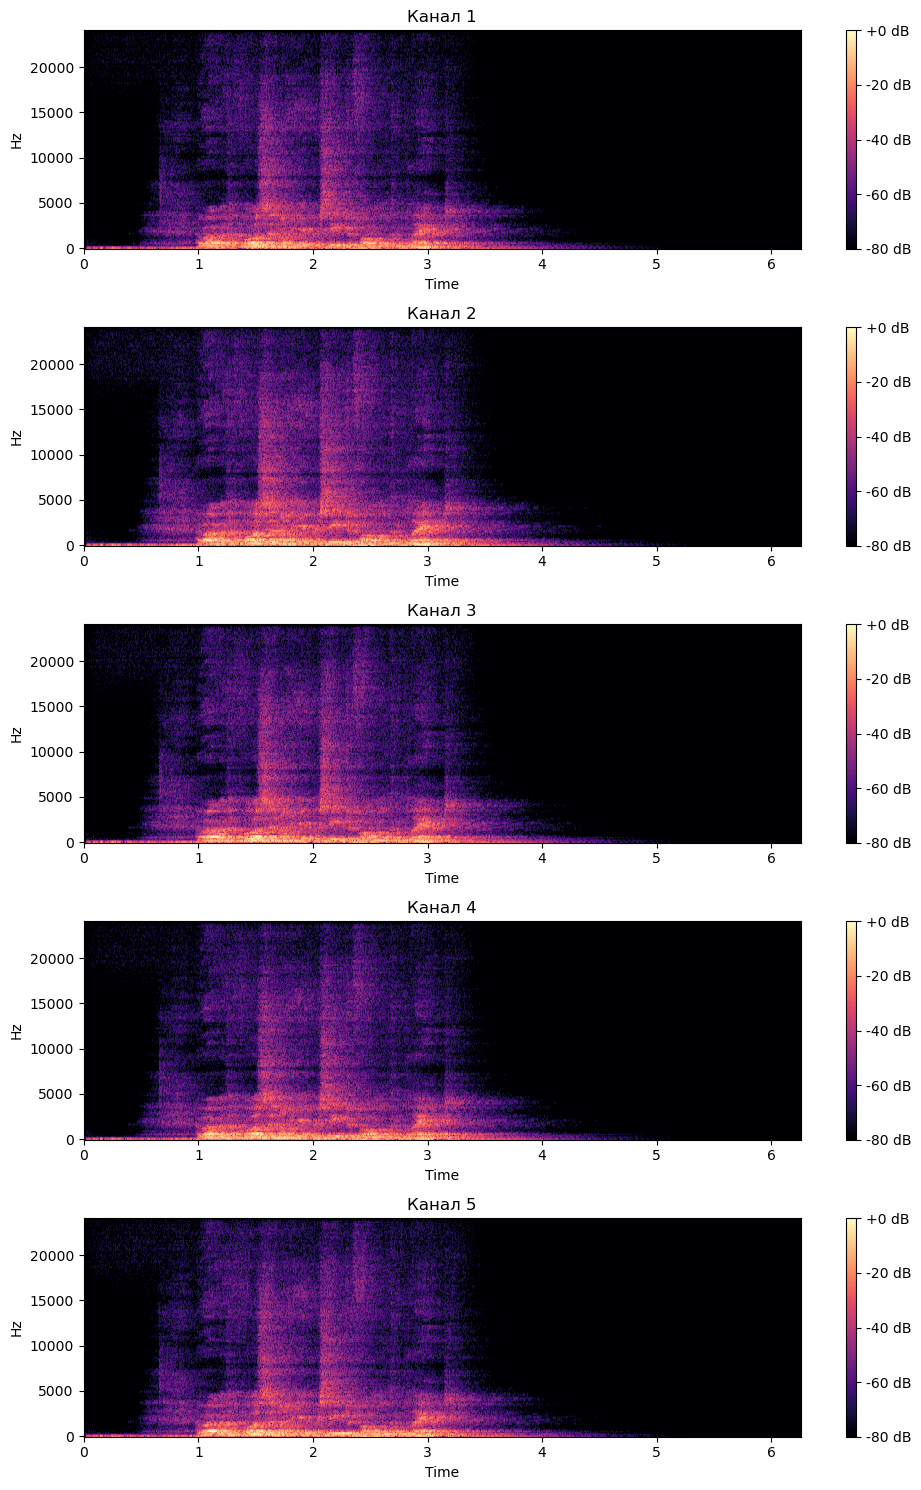

In [30]:
plot_audio_spectrogram(y_reverbed, sr)

In [31]:
def wpe_multi(
    y_multi, sr,
    n_fft=1024, hop=256, win=1024, window="hann", eps=1e-9,
    D=3, L=10, N=3, reg=1e-6, ref=0
):

    if y_multi.ndim == 1:
        y_multi = y_multi[None, :]

    M, N_samp = y_multi.shape

    Y_list = []
    for m in range(M):
        Ym = librosa.stft(y_multi[m], n_fft=n_fft, hop_length=hop,
                          win_length=win, window=window)
        Y_list.append(Ym)
    F, T = Y_list[0].shape
    for Yk in Y_list:
        assert Yk.shape == (F, T)
    Y = np.stack(Y_list, axis=0)

    Z_ref = np.zeros((F, T), dtype=Y.dtype)

    t_min = D + L - 1
    if T <= t_min:
        z_hat = librosa.istft(Y[ref], hop_length=hop, win_length=win, window=window, length=N_samp)
        return z_hat

    idx = np.arange(t_min, T)
    T_eff = idx.size
    K = M * L

    for f in range(F):
        Y_f = Y[:, f, :]
        if np.allclose(Y_f, 0):
            Z_ref[f, :] = Y[ref, f, :]
            continue

        X = np.zeros((K, T_eff), dtype=Y.dtype)
        row = 0
        for l in range(L):
            t_idx = idx - D - l
            X[row:row+M, :] = Y_f[:, t_idx]
            row += M

        y_ref = Y_f[ref, :]
        lam_full = np.maximum(moving_avg_power(y_ref, win_len=L), eps)
        lam = lam_full[idx]

        for _ in range(N):
            A = (X.T) / lam[:, None]
            AH = A.conj().T

            b = y_ref[idx] / lam

            R = AH @ A
            R += reg * np.eye(K, dtype=R.dtype)
            p = AH @ b

            g = np.linalg.solve(R, p)

            pred_ref = (X.conj().T @ g)
            z_valid = y_ref[idx] - pred_ref

            power_all = np.abs(y_ref)**2
            power_all[idx] = np.abs(z_valid)**2
            lam_full = np.maximum(moving_avg_power(power_all, win_len=L), eps)
            lam = lam_full[idx]

        Z_ref[f, :t_min] = y_ref[:t_min]
        Z_ref[f, idx]   = z_valid

    y_hat = librosa.istft(Z_ref, hop_length=hop, win_length=win,
                          window=window, length=N_samp)
    return y_hat

In [32]:
y_wpe = wpe_multi(y_reverbed, sr, D=3, L=15, N=3)

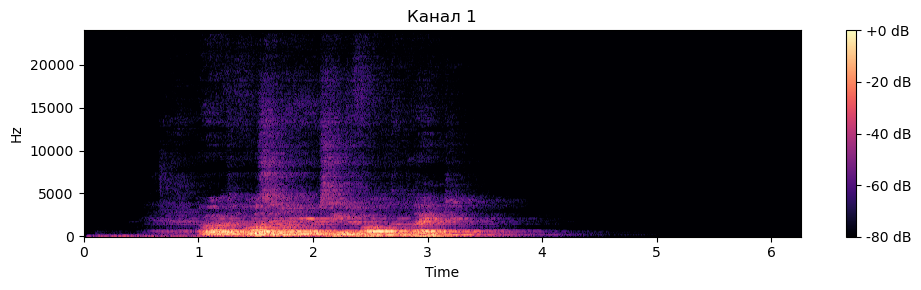

In [33]:
plot_audio_spectrogram(y_wpe, sr)

In [34]:
sf.write(path_output_multi / "test.flac", y_wpe, sr)

In [35]:
print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))
print("DNSMOS:", DNSMOS(y_wpe, sr))

Для очищенного
FWSegSNR: -7.285684807527649
CD: 118.01697060717085
DNSMOS: [[2.3213594 2.5804985 1.857226 ]]


In [36]:
path_clean = Path("clean")

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
dnsmos_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = sf.read(path_clean / file.name)
    y_reverbed = reverb_audio_multi(y_clean, sr)
    y_wpe = wpe_multi(y_reverbed, sr, D=3, L=15, N=3)

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    dnsmos_metric[audio_index] = DNSMOS(y_wpe, sr)[0, 0]
    audio_index += 1
    
    sf.write(path_output_multi / file.name, y_wpe, sr)